# Projeto Final: Introdução a Ciência dos Dados

Grupo:
- Henrique Soares Assumpção e Silva, 2020006620, henriquesas2020@ufmg.br

Dataset: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

Vídeo youtube: https://youtu.be/vDgtIGwUPn4

Este projeto tem como objetivo estudar o dataset "Suicides Rate Overview 1985 to 2016", que contém um conjunto de dados sobre diversos países com respeito ao número de suicídios por grupo demográfico em cada um dos 31 anos analizados. A pergunta principal que motiva esse estudo é: "Será que conseguimos observar padrões nos dados que expliquem o número de suicídios de um país? Além disso, será que é possível construir um modelo de aprendizado de máquina para prever tais valores?"

## Imports

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
import xgboost as xgb
import catboost as cb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Carregando os dados

In [2]:
# Primeiramente carregamos os dados do arquivo data.csv
df = pd.read_csv("data.csv")
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (27820, 12)


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [4]:
# Pequena conversão dos valores em gdp_for_year para facilitar a manipulação de dados
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].apply(lambda x: int(x.replace(",",""))) ## str -> int

O dataset em questão possui 12 features, sendo:
- "country": Variável string que informa o nome do país
- "year": Variável int que informa o ano da amostra
- "sex": Variável string que informa o sexo da população da amostra
- "age": Variável string que informa a faixa etária da população da amostra
- "suicides_no": Variável int que informa o número de suicídios, que é o target
- "population": Variável int que informa a população do grupo demográfico da amostra para aquele ano
- "suicides/100k pop": Variável float que é apenas o número de suicídios por 100k habitantes
- "country-year": Variável string que agrega a variável "country" e a variável "year"
- "HDI for year": Variável float que representa o IDH do país para um dado ano
- "gdp_for_year": Variável float que representa o PIB do país para um dado ano
- "gdp_per_capita":Variável float que representa o PIB per capita do país para um dado ano
- "generation": Variável string que indica a qual geração pertence o grupo demográfico de uma dada amostra


In [5]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000


## Análise exploratória

### Gráficos iniciais

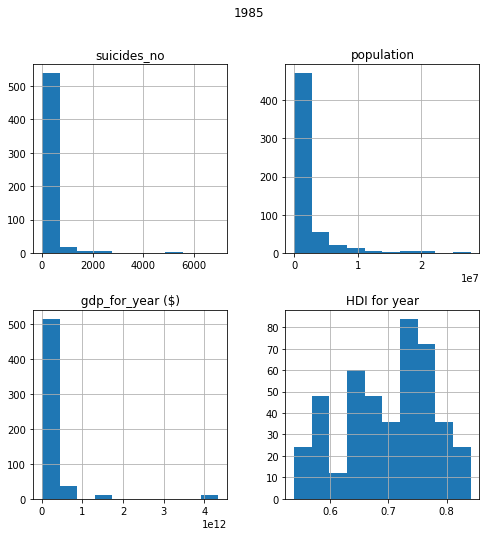

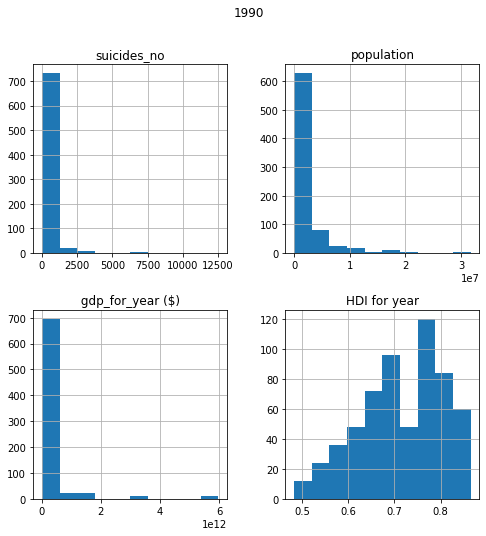

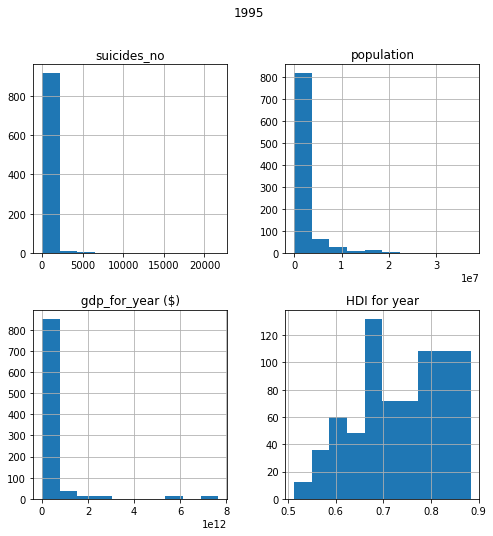

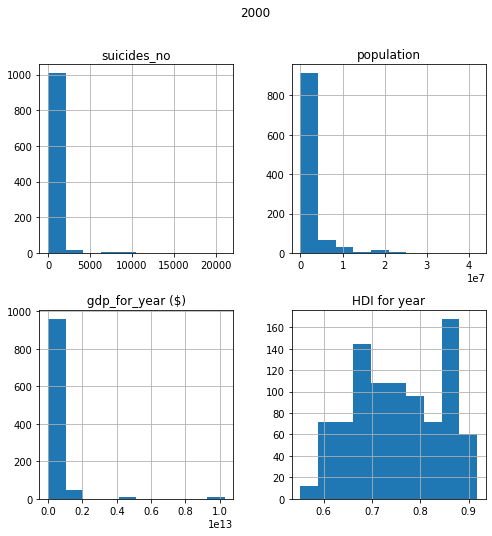

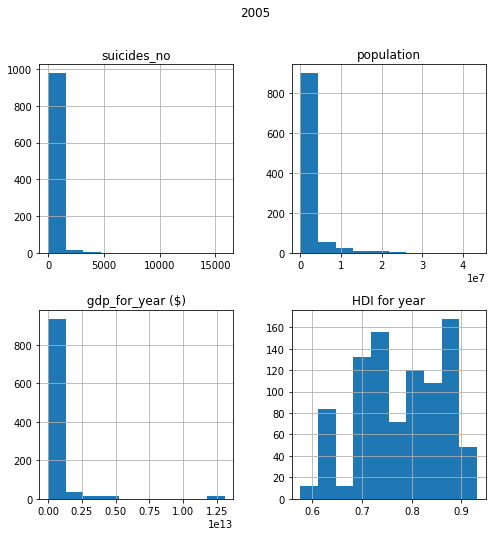

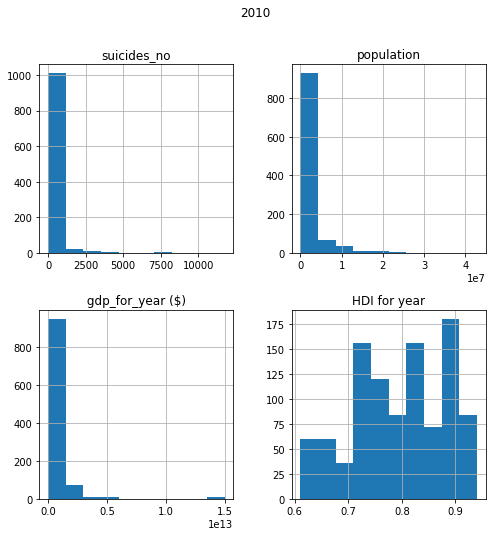

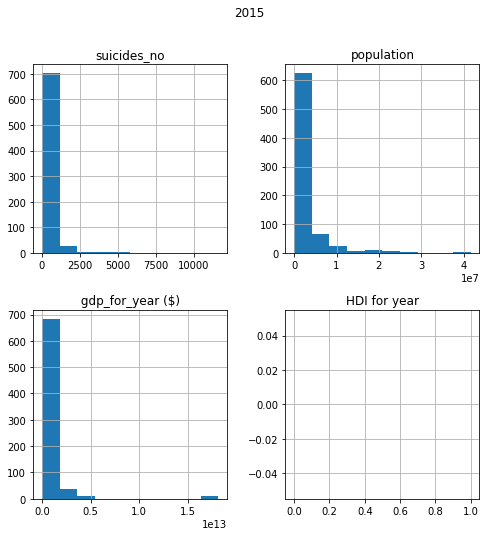

In [6]:
# Plotanto os histogramas para o número de suicídios, população, PIB e IDH a cada cinco anos
df_grouped = df.groupby("year")

for year_counter,(year,data) in enumerate(df_grouped):
    if year_counter % 5 == 0:
        data[['suicides_no','population',' gdp_for_year ($) ','HDI for year']].hist(grid=True,bins=10,figsize=(8,8))
        plt.suptitle(f"{year}")

### Análise de caso: Brasil

Inicialmente, iremos analizar os índices de suicídio no Brasil. Os dados do dataset apresentam o número de suicídios por geração(atrelado à idade) por gênero. Primeiramente, vamos apresentar algumas estatísticas e gráficos para todo o intervalo contemplado.

In [7]:
country_groupby = df.groupby(['country']).groups
br_df = df.loc[country_groupby['Brazil']]

In [8]:
# Tirando as correlações trivialmente esperadas, e.g. gdp_for_year e gdp_per_capita, 
# a tabela de correlações apenas mostra que o número de suicídios esta relativamente correlacionado com o tamanho da população,
# algo que no entanto, também já era de se esperar
br_df.corr()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
year,1.000000,0.264806,0.280673,0.044983,0.997391,0.863840,0.839049
suicides_no,0.264806,1.000000,0.420440,0.434466,0.258756,0.233770,0.227476
population,0.280673,0.420440,1.000000,-0.412420,0.296896,0.237820,0.231104
suicides/100k pop,0.044983,0.434466,-0.412420,1.000000,0.053730,0.038024,0.038782
HDI for year,0.997391,0.258756,0.296896,0.053730,1.000000,0.913183,0.906527
gdp_for_year ($),0.863840,0.233770,0.237820,0.038024,0.913183,1.000000,0.997200
gdp_per_capita ($),0.839049,0.227476,0.231104,0.038782,0.906527,0.997200,1.000000


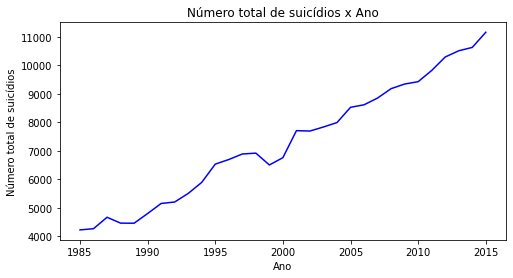

In [9]:
# Vamos calcular o valor total de suicídios por ano, e então plotar esse valor ao longo do tempo
fix,ax = plt.subplots(1,1,figsize=(8,4))
years = pd.unique(br_df['year'])
suicides_sum = [br_df[br_df['year'] == year]['suicides_no'].sum() for year in years]
ax.set_xlabel('Ano')
ax.set_ylabel('Número total de suicídios')
ax.set_title("Número total de suicídios x Ano")
ax.plot(years,suicides_sum,'b',ms='4')

O número total de suicídios parece claramente aumentar ao longo dos anos.
No entanto, é fácil ver que esse aumento não é linear, e encontrar uma curva que melhor o aproxime será tarefa da seção de regressão.
Agora, olharemos para algumas variações do gráfico

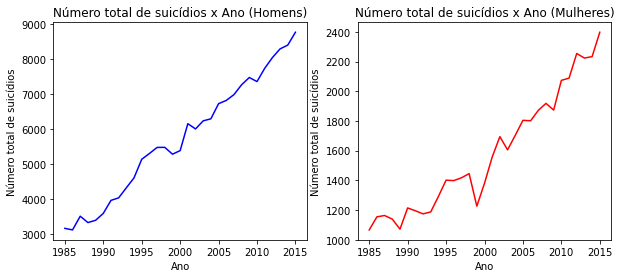

In [ ]:
# Homens x Mulheres
fix,ax = plt.subplots(1,2,figsize=(10,4))
years = pd.unique(br_df['year'])
suicides_sum_male = [br_df[br_df['sex'] == 'male'][br_df['year'] == year]['suicides_no'].sum() for year in years]
suicides_sum_female = [br_df[br_df['sex'] == 'female'][br_df['year'] == year]['suicides_no'].sum() for year in years]

ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Número total de suicídios')
ax[0].set_title("Número total de suicídios x Ano (Homens)")
ax[0].plot(years,suicides_sum_male,'b',ms='4')

ax[1].set_xlabel('Ano')
ax[1].set_ylabel('Número total de suicídios')
ax[1].set_title("Número total de suicídios x Ano (Mulheres)")
ax[1].plot(years,suicides_sum_female,'r',ms='4')

Text(0.5, 0, 'Ano')

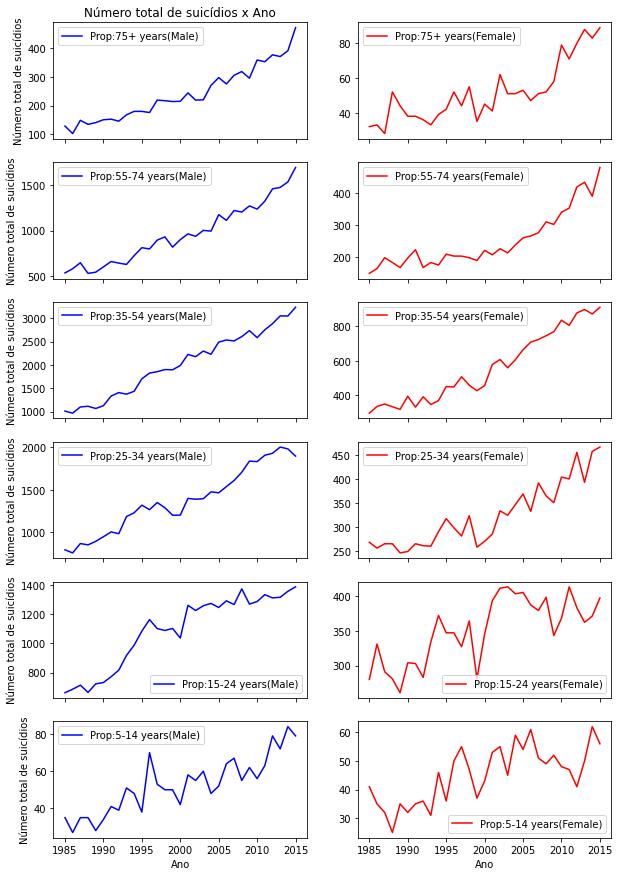

In [10]:
# Número de suicídios por faixa etária
ages = pd.unique(br_df['age'])
fix,ax = plt.subplots(6,2,figsize=(10,15),sharex=True)
years = pd.unique(br_df['year'])
for idx,age in enumerate(ages):
    curr_prop_male = [br_df[br_df['age'] == age][br_df['year'] == year][br_df['sex'] == 'male']['suicides_no'] for year in years]
    curr_prop_female = [br_df[br_df['age'] == age][br_df['year'] == year][br_df['sex'] == 'female']['suicides_no'] for year in years]
    ax[idx,0].plot(years,curr_prop_male,'b',ms='4',label=f'Prop:{age}(Male)')
    ax[idx,1].plot(years,curr_prop_female,'r',ms='4',label=f'Prop:{age}(Female)')

    ax[idx,0].set_ylabel('Número total de suicídios')
    ax[idx,0].legend()
    ax[idx,1].legend()
ax[0,0].set_title("Número total de suicídios x Ano")
ax[idx,0].set_xlabel('Ano')
ax[idx,1].set_xlabel('Ano')

No entanto, analizar o valor bruto de suicídios pode fornecer uma representação errada do comportamento real de um país: temos que levar em consideração o aumento populacional, i.e., não podemos afirmar que a taxa de suicídio aumentou somente baseado no número absoluto. Por esse fato, iremos analizar os dados w.r.t. número de suicídios por 100k habitantes

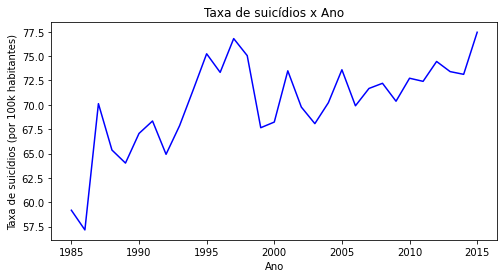

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(8,4))
years = pd.unique(br_df['year'])
suicides_sum = [br_df[br_df['year'] == year]['suicides/100k pop'].sum() for year in years]
ax.set_xlabel('Ano')
ax.set_ylabel('Taxa de suicídios (por 100k habitantes)')
ax.set_title("Taxa de suicídios x Ano")
ax.plot(years,suicides_sum,'b',ms='4')

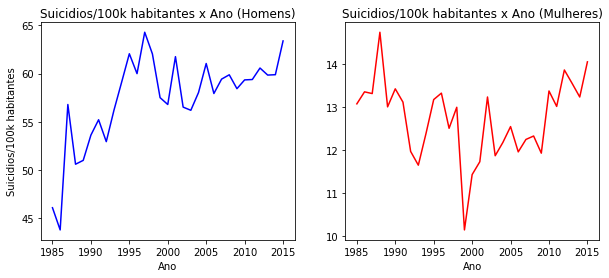

In [ ]:
fix,ax = plt.subplots(1,2,figsize=(10,4))
years = pd.unique(br_df['year'])
suicides_sum_male = [br_df[br_df['sex'] == 'male'][br_df['year'] == year]['suicides/100k pop'].sum() for year in years]
suicides_sum_female = [br_df[br_df['sex'] == 'female'][br_df['year'] == year]['suicides/100k pop'].sum() for year in years]

ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Suicidios/100k habitantes')
ax[0].set_title("Suicidios/100k habitantes x Ano (Homens)")
ax[0].plot(years,suicides_sum_male,'b',ms='4')

ax[1].set_xlabel('Ano')
ax[1].set_title("Suicidios/100k habitantes x Ano (Mulheres)")
ax[1].plot(years,suicides_sum_female,'r',ms='4')

Text(0.5, 0, 'Ano')

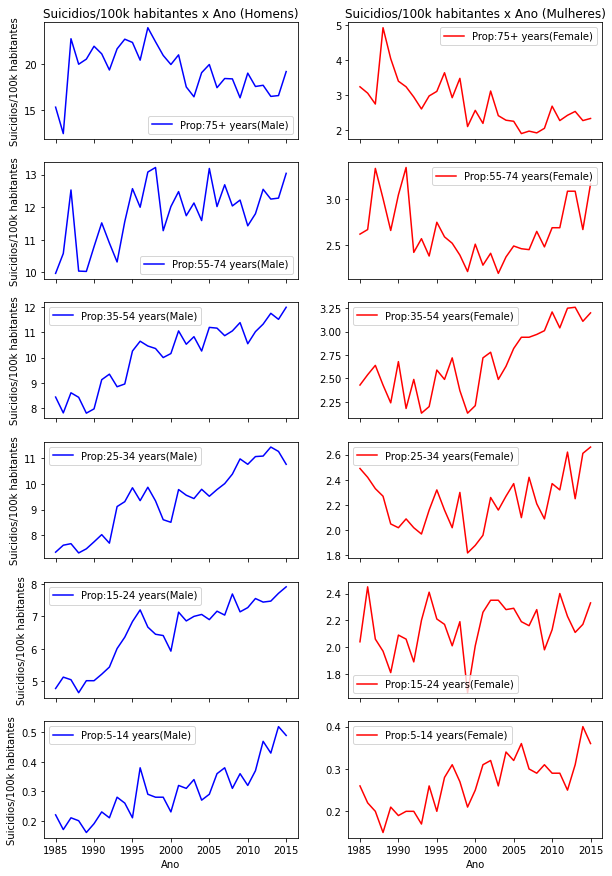

In [ ]:
ages = pd.unique(br_df['age'])
fix,ax = plt.subplots(6,2,figsize=(10,15),sharex=True)
years = pd.unique(br_df['year'])
for idx,age in enumerate(ages):
    curr_prop_male = [br_df[br_df['age'] == age][br_df['year'] == year][br_df['sex'] == 'male']['suicides/100k pop'] for year in years]
    curr_prop_female = [br_df[br_df['age'] == age][br_df['year'] == year][br_df['sex'] == 'female']['suicides/100k pop'] for year in years]
    ax[idx,0].plot(years,curr_prop_male,'b',ms='4',label=f'Prop:{age}(Male)')
    ax[idx,1].plot(years,curr_prop_female,'r',ms='4',label=f'Prop:{age}(Female)')

    ax[idx,0].set_ylabel('Suicidios/100k habitantes')
    ax[idx,0].legend()
    ax[idx,1].legend()
ax[0,0].set_title("Suicidios/100k habitantes x Ano (Homens)")
ax[0,1].set_title("Suicidios/100k habitantes x Ano (Mulheres)")
ax[idx,0].set_xlabel('Ano')
ax[idx,1].set_xlabel('Ano')

A partir das análises acima, podemos tirar algumas conclusões:
- A taxa de suicídio para brasileiros, de forma geral, está de fato aumentando desde 1985
- No entanto, é fácil ver que tanto em valores absolutos quanto em valores relativos, as estatísticas de suicídio para homens são significativamente maiores que para as mulhes, ou seja, o aumento na taxa de suicídio dos homens com certeza foi o fator mais influente para o aumento generalizado da população
- Podemos perceber que a taxa de suicídio para as mulheres não aumentou de forma significativa com respeito a taxa de 1985 (foi de 13 para quase 14), enquanto a dos homens aumentou considerávelmente (de 45 para quase 65)

### Análise de Caso: EUA

In [ ]:
us_df = df.loc[country_groupby['United States']]

In [ ]:
us_df.corr()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
year,1.000000,0.106921,0.221208,-0.060746,0.994200,0.995087,0.996908
suicides_no,0.106921,1.000000,0.549784,0.602962,0.123849,0.109887,0.106406
population,0.221208,0.549784,1.000000,-0.170397,0.232421,0.220855,0.220970
suicides/100k pop,-0.060746,0.602962,-0.170397,1.000000,-0.046703,-0.057606,-0.061157
HDI for year,0.994200,0.123849,0.232421,-0.046703,1.000000,0.984216,0.990487
gdp_for_year ($),0.995087,0.109887,0.220855,-0.057606,0.984216,1.000000,0.998174
gdp_per_capita ($),0.996908,0.106406,0.220970,-0.061157,0.990487,0.998174,1.000000


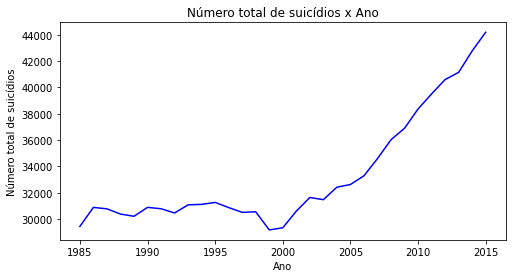

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(8,4))
years = pd.unique(us_df['year'])
suicides_sum = [us_df[us_df['year'] == year]['suicides_no'].sum() for year in years]
ax.set_xlabel('Ano')
ax.set_ylabel('Número total de suicídios')
ax.set_title("Número total de suicídios x Ano")
ax.plot(years,suicides_sum,'b',ms='4')

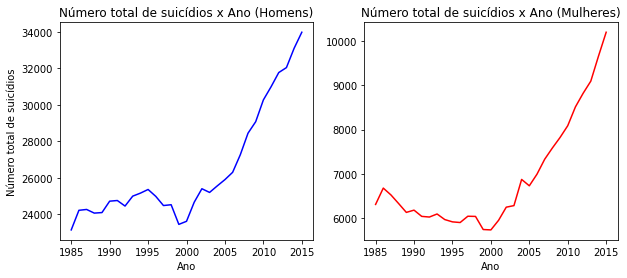

In [ ]:
# Homens x Mulheres
fix,ax = plt.subplots(1,2,figsize=(10,4))
years = pd.unique(us_df['year'])
suicides_sum_male = [us_df[us_df['sex'] == 'male'][us_df['year'] == year]['suicides_no'].sum() for year in years]
suicides_sum_female = [us_df[us_df['sex'] == 'female'][us_df['year'] == year]['suicides_no'].sum() for year in years]

ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Número total de suicídios')
ax[0].set_title("Número total de suicídios x Ano (Homens)")
ax[0].plot(years,suicides_sum_male,'b',ms='4')

ax[1].set_xlabel('Ano')
ax[1].set_title("Número total de suicídios x Ano (Mulheres)")
ax[1].plot(years,suicides_sum_female,'r',ms='4')

Text(0.5, 0, 'Ano')

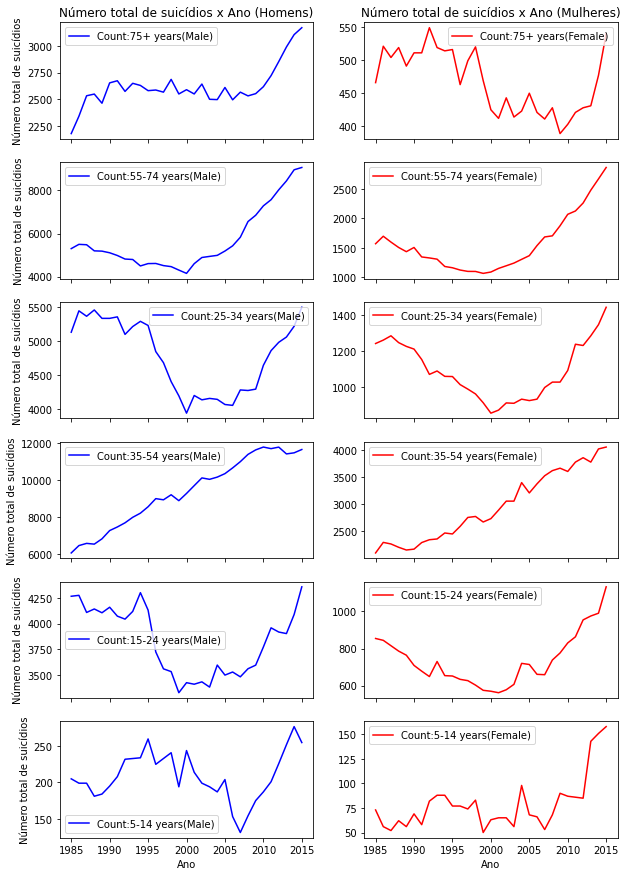

In [ ]:
# Gráficos feitos por faixa etária
ages = pd.unique(us_df['age'])
fix,ax = plt.subplots(6,2,figsize=(10,15),sharex=True)
years = pd.unique(us_df['year'])
for idx,age in enumerate(ages):
    curr_data_male = [us_df[us_df['age'] == age][us_df['year'] == year][us_df['sex'] == 'male']['suicides_no'] for year in years]
    curr_data_female = [us_df[us_df['age'] == age][us_df['year'] == year][us_df['sex'] == 'female']['suicides_no'] for year in years]
    ax[idx,0].set_ylabel('Número total de suicídios')
    ax[idx,0].plot(years,curr_data_male,'b',ms='4',label=f'Count:{age}(Male)')
    ax[idx,1].plot(years,curr_data_female,'r',ms='4',label=f'Count:{age}(Female)')

    ax[idx,0].legend()
    ax[idx,1].legend()
ax[0,0].set_title("Número total de suicídios x Ano (Homens)")
ax[0,1].set_title("Número total de suicídios x Ano (Mulheres)")
ax[idx,0].set_xlabel('Ano')
ax[idx,1].set_xlabel('Ano')

Pelos mesmos motivos ressaltados anteriormente, iremos também realizar uma análize w.r.t. a taxa de suicídios por 100k habitantes

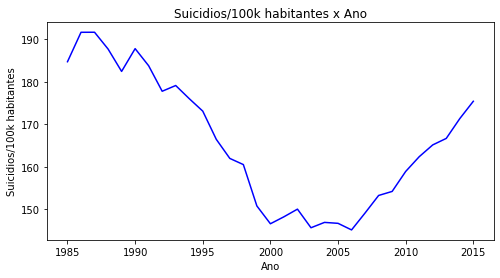

In [ ]:
fix,ax = plt.subplots(1,1,figsize=(8,4))
years = pd.unique(us_df['year'])
suicides_sum = [us_df[us_df['year'] == year]['suicides/100k pop'].sum() for year in years]
ax.set_xlabel('Ano')
ax.set_ylabel('Suicidios/100k habitantes')
ax.set_title("Suicidios/100k habitantes x Ano")
ax.plot(years,suicides_sum,'b',ms='4')

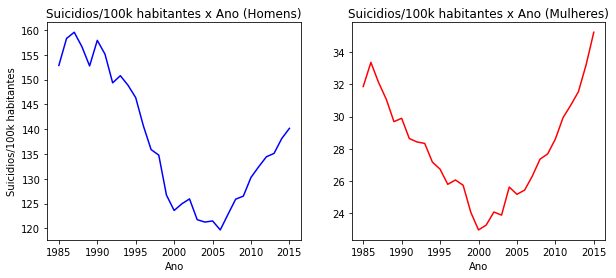

In [ ]:
fix,ax = plt.subplots(1,2,figsize=(10,4))
years = pd.unique(us_df['year'])
suicides_sum_male = [us_df[us_df['sex'] == 'male'][us_df['year'] == year]['suicides/100k pop'].sum() for year in years]
suicides_sum_female = [us_df[us_df['sex'] == 'female'][us_df['year'] == year]['suicides/100k pop'].sum() for year in years]

ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Suicidios/100k habitantes')
ax[0].set_title("Suicidios/100k habitantes x Ano (Homens)")
ax[0].plot(years,suicides_sum_male,'b',ms='4')

ax[1].set_xlabel('Ano')
ax[1].set_title("Suicidios/100k habitantes x Ano (Mulheres)")
ax[1].plot(years,suicides_sum_female,'r',ms='4')

Text(0.5, 0, 'Ano')

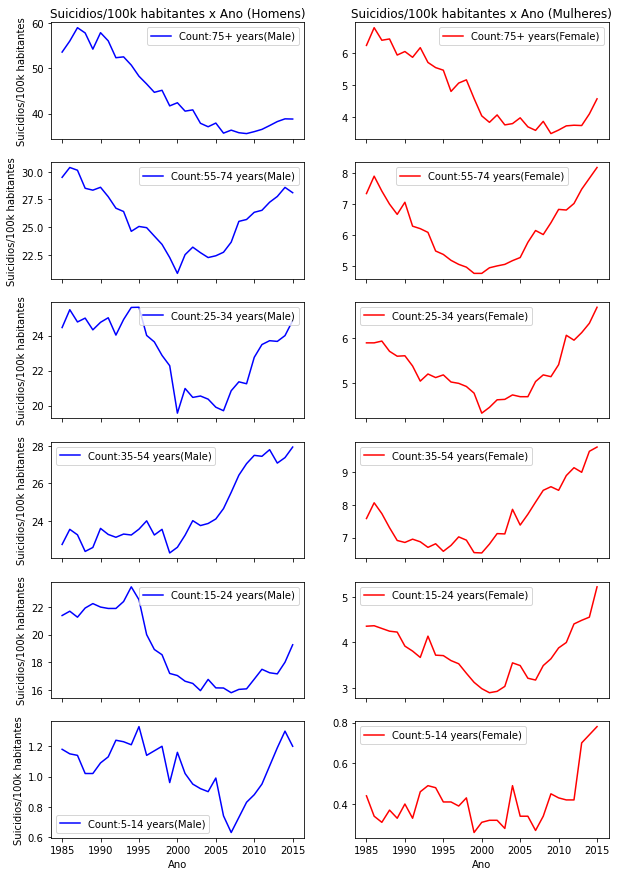

In [ ]:
ages = pd.unique(us_df['age'])
fix,ax = plt.subplots(6,2,figsize=(10,15),sharex=True)
years = pd.unique(us_df['year'])
for idx,age in enumerate(ages):
    curr_data_male = [us_df[us_df['age'] == age][us_df['year'] == year][us_df['sex'] == 'male']['suicides/100k pop'] for year in years]
    curr_data_female = [us_df[us_df['age'] == age][us_df['year'] == year][us_df['sex'] == 'female']['suicides/100k pop'] for year in years]
    ax[idx,0].set_ylabel('Suicidios/100k habitantes')
    ax[idx,0].plot(years,curr_data_male,'b',ms='4',label=f'Count:{age}(Male)')
    ax[idx,1].plot(years,curr_data_female,'r',ms='4',label=f'Count:{age}(Female)')

    ax[idx,0].legend()
    ax[idx,1].legend()
ax[0,0].set_title("Suicidios/100k habitantes x Ano (Homens)")
ax[0,1].set_title("Suicidios/100k habitantes x Ano (Mulheres)")
ax[idx,0].set_xlabel('Ano')
ax[idx,1].set_xlabel('Ano')

As análises feitas nos permitem realizar as seguintes observações:
- A taxa de suicídio nos EUA vem aumentando significativamente desde o ano 2006, antes disso ela vinha em uma quda constante
- A taxa de suicídio entre homens nos EUA é gritantemente maior que a taxa entre mulheres
- Nos últimos anos, a grande maioria das faixas etárias parecem estar sofrendo com um aumento na taxa de suícidios 

De forma geral, podemos perceber que os EUA possuem uma taxa de suicídio significativamente maior que a do brasil, e os estudos de casos nos permitiram inferir importantes insights com respeito a ambos os países

### Testes de hipótese

In [ ]:
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
# Função que computa alguma estatística(e.g. média) um número n_samples de vezes de acordo com a lógica bootstrap
def compute_bootstrap_stat(data:pd.DataFrame,n_samples:int,stat_func,random_state:int=123) -> np.array:
    stats_arr = np.zeros(n_samples)
    for i in range(n_samples):
        curr_sample = data.sample(len(data),replace=True,random_state=(random_state+i))
        stats_arr[i] = stat_func(curr_sample)
    return stats_arr
# Função que plota o intervalo de confiança para uma dada estatística
def plot_ci(stats_arr:np.array,confidence:float,xlabel:str=None,ylabel:str="Perc(%)"):  
    assert confidence > 0    
    if confidence < 1:
        confidence = confidence * 100 # converts to perc    
    alpha = 100 - confidence    
    lb = np.percentile(stats_arr,alpha/2)
    ub = np.percentile(stats_arr,confidence + (alpha/2))
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.distplot(stats_arr, hist=True, kde=True, 
                    bins=40, color = 'black',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 4},ax=ax)
    x_min,x_max = plt.gca().get_xlim()
    kde = gaussian_kde(stats_arr)
    pos = np.linspace(np.min(stats_arr), np.max(stats_arr), 1000)
    shade = np.linspace(lb, ub, 300)
    out_low = np.linspace(x_min, lb, 300)
    out_up = np.linspace(ub, x_max, 300)
    plt.fill_between(shade, kde(shade), alpha=0.45, color='blue',)
    plt.fill_between(out_low, kde(out_low), alpha=0.45, color='red',)
    plt.fill_between(out_up, kde(out_up), alpha=0.45, color='red',)
    plt.tight_layout()
    plt.title(f"IC({confidence}%) -> ({lb:.3f},{ub:.3f})")
    plt.show()
# Função que embaralha os dados e calcula a estatísica de interesse para os testes de hipótese w.r.t. gênero
def shuffle_data_gender(df:pd.DataFrame,num_samples:int=10000) -> np.array:
    diffs = np.zeros(num_samples)
    filter = df['sex'] == 'male'
    for i in range(num_samples):
        np.random.seed(i)
        np.random.shuffle(filter.values)
        diffs[i] = df[filter]['num_suicides'].mean() - df[~filter]['num_suicides'].mean()
    return diffs

Inicialmente, vamos obter intervalos de confiança para algumas estatísticas relevantes para os dados.

#### Brasil

In [ ]:
# Podemos obter intervalos de confiança para o valor médio do número total de suicídios ao longo dos anos
suicides_sum = np.array([br_df[br_df['year'] == year]['suicides_no'].sum() for year in years])

sample_mean = suicides_sum.mean()
sample_std = suicides_sum.std(ddof=1)/np.sqrt(len(suicides_sum))
z_value = 1.96 # 95% de confiança

stat = z_value * sample_std
print(f"IC(95%) -> ({sample_mean - stat},{sample_mean + stat})")

IC(95%) -> (6563.698441726516,8056.495106660581)


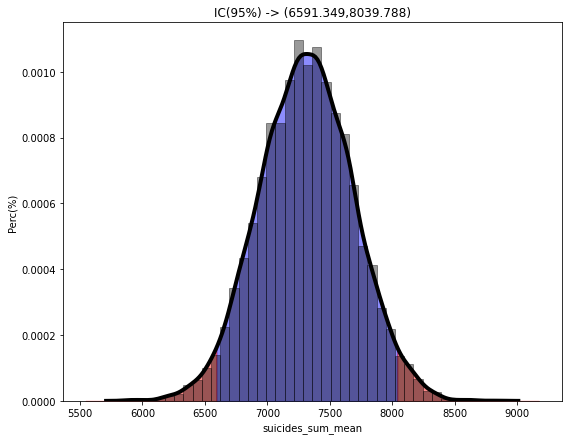

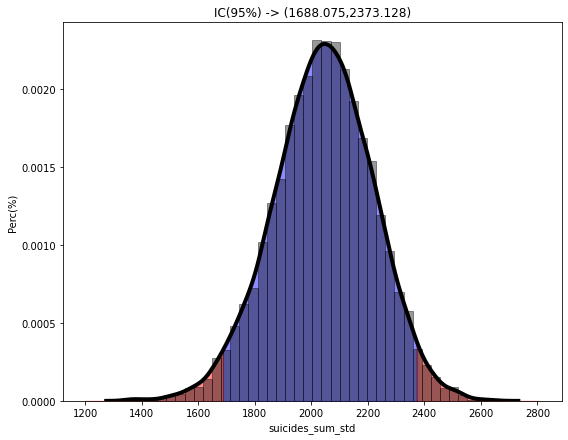

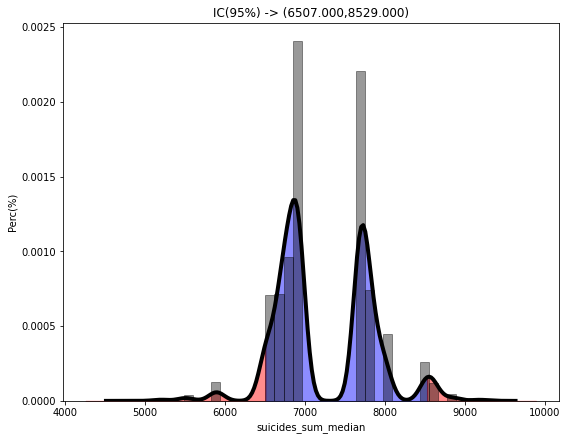

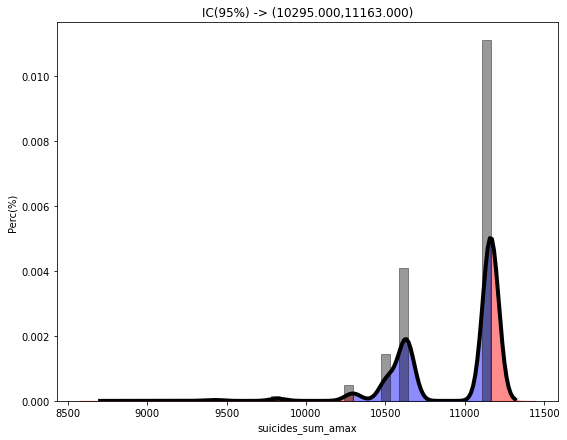

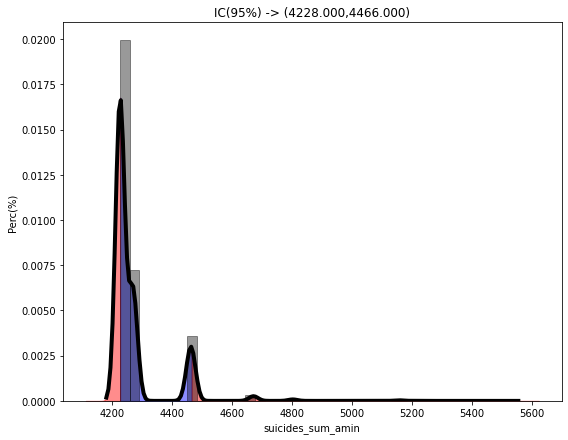

In [ ]:
# Podemos também gerar intervalos de confiança para outras estatísticas, como desvio padrão, mediana, máximo e mínimo
stat_funcs = [np.mean,np.std,np.median,np.max,np.min]
confidence = 95
for stat_func in stat_funcs:
    stats = compute_bootstrap_stat(pd.DataFrame(suicides_sum,columns=['suicides_sum']),n_samples=10000,stat_func=stat_func) 
    plot_ci(stats,confidence,f"suicides_sum_{stat_func.__name__}") # plota o intervalo de confianca de 95%

Formulamos a seguinte hipótese:
$$H_0: \mu_{male} = \mu_{female}$$

$$H_1: \mu_{male} \neq \mu_{female}$$

Isto é, será que a média do número total de suicídios ao longo dos anos para a população masculina é de fato diferente da feminina de forma estatisticamente significativa?

In [ ]:
suicides_sum_male =np.array([[float(br_df[br_df['sex'] == 'male'][br_df['year'] == year]['suicides_no'].sum()),'male'] for year in years],dtype=object)
suicides_sum_female = np.array([[float(br_df[br_df['sex'] == 'female'][br_df['year'] == year]['suicides_no'].sum()),'female'] for year in years],dtype=object)
original_stat = suicides_sum_male[:,0].mean() - suicides_sum_female[:,0].mean()
original_stat

4147.8387096774195

In [ ]:
sui_sum_df = pd.DataFrame(np.concatenate([suicides_sum_male,suicides_sum_female],axis=0),columns=['num_suicides','sex'])
diffs = shuffle_data_gender(sui_sum_df)

p_value = (diffs > original_stat).mean()
print(f"O P-valor calculado(5% de significância) foi: {p_value}")

O P-valor calculado(5% de significância) foi: 0.0


#### EUA

In [ ]:
# Podemos obter intervalos de confiança para o valor médio do número total de suicídios ao longo dos anos
suicides_sum = np.array([us_df[us_df['year'] == year]['suicides_no'].sum() for year in years])

sample_mean = suicides_sum.mean()
sample_std = suicides_sum.std(ddof=1)/np.sqrt(len(suicides_sum))
z_value = 1.96 # 95% de confiança

stat = z_value * sample_std
print(f"IC(95%) -> ({sample_mean - stat},{sample_mean + stat})")

IC(95%) -> (31839.484429896955,34871.0316991353)


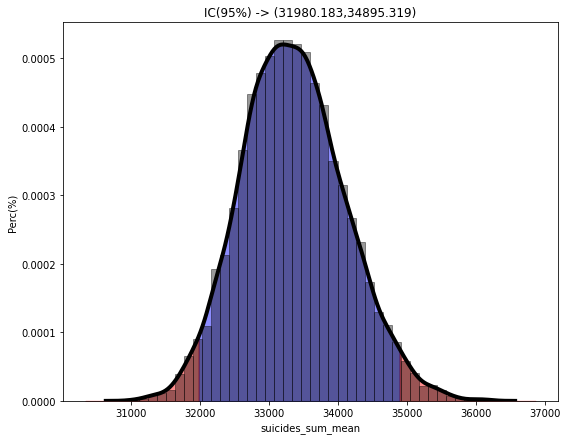

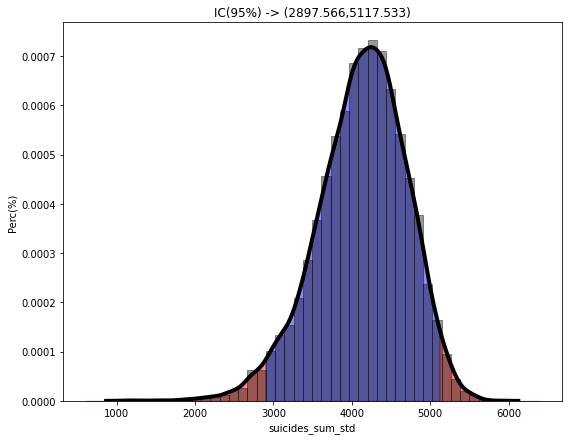

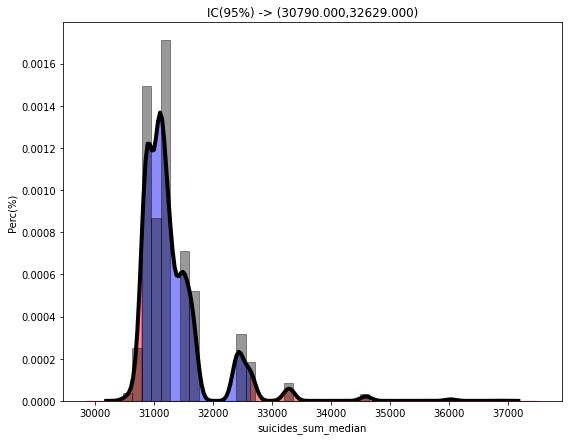

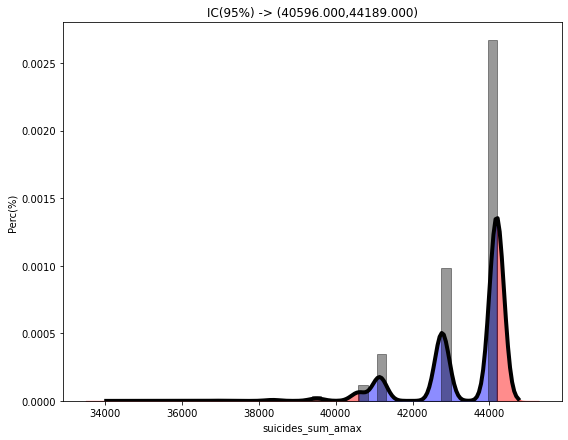

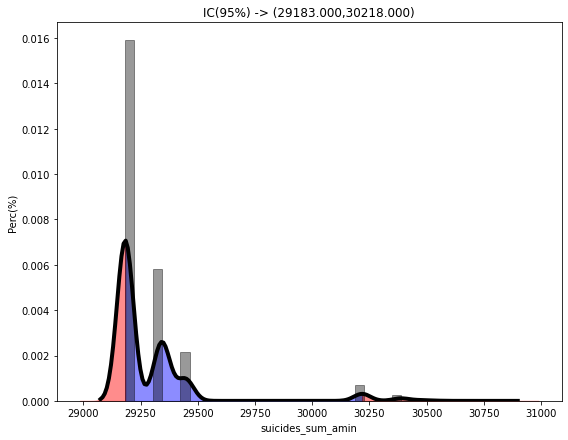

In [ ]:
stat_funcs = [np.mean,np.std,np.median,np.max,np.min]
confidence = 95
for stat_func in stat_funcs:
    stats = compute_bootstrap_stat(pd.DataFrame(suicides_sum,columns=['suicides_sum']),n_samples=10000,stat_func=stat_func) 
    plot_ci(stats,confidence,f"suicides_sum_{stat_func.__name__}") # plota o intervalo de confianca de 95%

Formulamos a mesma hipótese formulada para o estudo de caso anterior:
$$H_0: \mu_{male} = \mu_{female}$$

$$H_1: \mu_{male} \neq \mu_{female}$$


In [ ]:
suicides_sum_male =np.array([[float(us_df[us_df['sex'] == 'male'][us_df['year'] == year]['suicides_no'].sum()),'male'] for year in years],dtype=object)
suicides_sum_female = np.array([[float(us_df[us_df['sex'] == 'female'][us_df['year'] == year]['suicides_no'].sum()),'female'] for year in years],dtype=object)
original_stat = suicides_sum_male[:,0].mean() - suicides_sum_female[:,0].mean()
original_stat

19561.903225806454

In [ ]:
sui_sum_df = pd.DataFrame(np.concatenate([suicides_sum_male,suicides_sum_female],axis=0),columns=['num_suicides','sex'])
diffs = shuffle_data_gender(sui_sum_df)

p_value = (diffs > original_stat).mean()
print(f"O P-valor calculado(5% de significância) foi: {p_value}")

O P-valor calculado(5% de significância) foi: 0.0


Os teste de hipótese realizados nos permitem inferir que as diferênças nas médias do número de suicídios entre homens e mulheres ao longo dos anos é de fato estatísticamente relevante, i.e., não é explicado pelo acaso, tanto para os EUA quanto para o Brasil

## Regressão e modelagem

Nessa seção, estamos interessados em construir um modelo de Regressão que seja capaz de prever o número de suicídios para um dado grupo demográfico de um país em um dado ano, e.g. prever o número de suicídios de pessoas idosas do sexo masculino na albânia para o ano de 2019.

### Transformações iniciais
1. Dropar colunas reduntantes/com muitos valores faltantes(no caso country-year e HDI for year respectivamente)
2. Transformar os valores string em dados categoricos
3. Remover a variável "suicides/100k pop", pois ela é apenas uma transformação da variável resposta

In [ ]:
DROP_COLS = True
ENCODE_STR = True
old_df = df.copy()
if DROP_COLS:
    cols_to_drop = ['country-year','HDI for year','suicides/100k pop']
    df.drop(axis=1,labels=cols_to_drop,inplace=True)


if ENCODE_STR:
    cols_to_transform = ['country','sex','age']
    le = LabelEncoder()
    for col in cols_to_transform:
        df[col] = le.fit_transform(df[col])
df.head()

,country,year,sex,age,suicides_no,population,gdp_for_year ($),gdp_per_capita ($),generation
0,0,1987,1,0,21,312900,2156624900,796,Generation X
1,0,1987,1,2,16,308000,2156624900,796,Silent
2,0,1987,0,0,14,289700,2156624900,796,Generation X
3,0,1987,1,5,1,21800,2156624900,796,G.I. Generation
4,0,1987,1,1,9,274300,2156624900,796,Boomers


### Criando os Splits

In [ ]:
Z_NORMALIZE = True 
y = df['suicides_no']
X = df.drop(axis=1,labels=['suicides_no','generation'])
print(f"Tamanho do dataset: {X.shape}")

TRAIN = True
TEST = False
assert TRAIN ^ TEST

test_size = 0.2
val_size = 0.1
seed = 1234

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=seed,test_size=0.2)

if Z_NORMALIZE: 
    cols_to_norm = ['population',' gdp_for_year ($) ','gdp_per_capita ($)']
    scaler = StandardScaler()
    scalers_dict = {}
    for col in cols_to_norm:
        X_train[col] = scaler.fit_transform(X_train[col].to_numpy().reshape(-1,1))
        X_test[col] = scaler.transform(X_test[col].to_numpy().reshape(-1,1))
        scalers_dict[col] = scaler

print(f"Tamanho do conjunto de treino: {X_train.shape}({(len(X_train)/len(df)) * 100:.2f}%)")
print(f"Tamanho do conjunto de teste: {X_test.shape}({(len(X_test)/len(df)) * 100:.2f}%)")

Tamanho do dataset: (27820, 7)
Tamanho do conjunto de treino: (22256, 7)(80.00%)
Tamanho do conjunto de teste: (5564, 7)(20.00%)


### Treinando os modelos tabulates(Regressão Linear, Regressão Lasso, XGBoost e CatBoost)

Nessa parte, iremos comparar quatro modelos de regressão, sendo dois deles modelos clássicos (Lasso e Regressão Linear), e dois deles modelos estado da arte para regressão e classificação (XGBoost e CatBoost).

Iremos também realizar uma validação cruzada com 5 splits para 5 seeds diferentes, totalizando 25 treinamentos para garantir que o modelo treinado é robusto e que os resultados são estatisticamente significativos

In [ ]:
from sklearn.model_selection import StratifiedKFold  

cv_seeds = [1243,5356,2313,6324,1313]

models = [Lasso(alpha=.1),
        LinearRegression(),
        xgb.XGBRegressor(max_depth=20,n_estimators=500,eval_metric='mae',objective='reg:squarederror'),
        cb.CatBoostRegressor(depth=10,iterations=500,loss_function='RMSE',cat_features=[0,1,2,3])]

model_errors = {model.__class__.__name__:[] for model in models}

for seed in cv_seeds:
    stf = StratifiedKFold(n_splits=5,random_state=seed,shuffle=True)
    print(f"Seed = {seed}")

    for idx,(train_idx,val_idx) in enumerate(stf.split(X_train,y_train)):
        print(f"CV {idx+1}")
        curr_X_train,curr_X_val = X_train.iloc[train_idx],X_train.iloc[val_idx]
        curr_y_train,curr_y_val = y_train.iloc[train_idx],y_train.iloc[val_idx]  
        for model in models:
            if model.__class__.__name__ == "XGBRegressor":
                model.fit(curr_X_train,curr_y_train,eval_set=[(curr_X_val,curr_y_val)],early_stopping_rounds=3,verbose=False)
            elif model.__class__.__name__ == "CatBoostRegressor":
                model.fit(curr_X_train,curr_y_train,eval_set=[(curr_X_val,curr_y_val)],early_stopping_rounds=3,verbose=False,use_best_model=True)
            else:
                model.fit(curr_X_train,curr_y_train)
            curr_val_error = mean_absolute_error(curr_y_val,model.predict(curr_X_val))
            print(f"{model.__class__.__name__} -> Curr validation loss: {curr_val_error:.2f}")
            
            model_errors[model.__class__.__name__].append(curr_val_error)
        print("\n")
    print("\n")

Seed = 1243
CV 1
Lasso -> Curr validation loss: 262.28
LinearRegression -> Curr validation loss: 262.45
XGBRegressor -> Curr validation loss: 27.03
CatBoostRegressor -> Curr validation loss: 40.78


CV 2
Lasso -> Curr validation loss: 259.94
LinearRegression -> Curr validation loss: 260.09
XGBRegressor -> Curr validation loss: 25.40
CatBoostRegressor -> Curr validation loss: 51.53


CV 3
Lasso -> Curr validation loss: 269.71
LinearRegression -> Curr validation loss: 269.85
XGBRegressor -> Curr validation loss: 31.78
CatBoostRegressor -> Curr validation loss: 62.34


CV 4
Lasso -> Curr validation loss: 258.43
LinearRegression -> Curr validation loss: 258.57
XGBRegressor -> Curr validation loss: 27.28
CatBoostRegressor -> Curr validation loss: 44.23


CV 5
Lasso -> Curr validation loss: 270.17
LinearRegression -> Curr validation loss: 270.32
XGBRegressor -> Curr validation loss: 24.33
CatBoostRegressor -> Curr validation loss: 39.24




Seed = 5356
CV 1
Lasso -> Curr validation loss: 263

Agora iremos analizar os resultados dos experimentos e gerar intervalos de confiança para os erros médios de validação para cada modelo, bem como obter os erros de teste segundo a métrica MAE (Mean Absolute Error)

In [ ]:
for model in models:
    curr_errors = np.array(model_errors[model.__class__.__name__])

    sample_mean = curr_errors.mean()
    sample_std = curr_errors.std(ddof=1)/np.sqrt(len(curr_errors))
    z_value = 1.96 # 95% de confiança

    stat = z_value * sample_std
    print(f"{model.__class__.__name__} -> IC(95%):({sample_mean - stat},{sample_mean + stat})")

Lasso -> IC(95%):(262.27435876154993,266.0014870794341)
LinearRegression -> IC(95%):(262.42294562317045,266.1514509363095)
XGBRegressor -> IC(95%):(26.27829597113631,28.476383846509748)
CatBoostRegressor -> IC(95%):(41.429102665826655,45.865251346740585)


In [ ]:
for model in models:
    curr_error = mean_absolute_error(y_test,model.predict(X_test))
    print(f"{model.__class__.__name__} -> Test Loss: {curr_error:.2f}")

Lasso -> Test Loss: 262.59
LinearRegression -> Test Loss: 262.75
XGBRegressor -> Test Loss: 25.68
CatBoostRegressor -> Test Loss: 45.05


Também é interessante analizar a distribuição das predições do modelo com respeito à distribuição dos dados de teste

Text(0.5, 0, '$y_{pred}$')

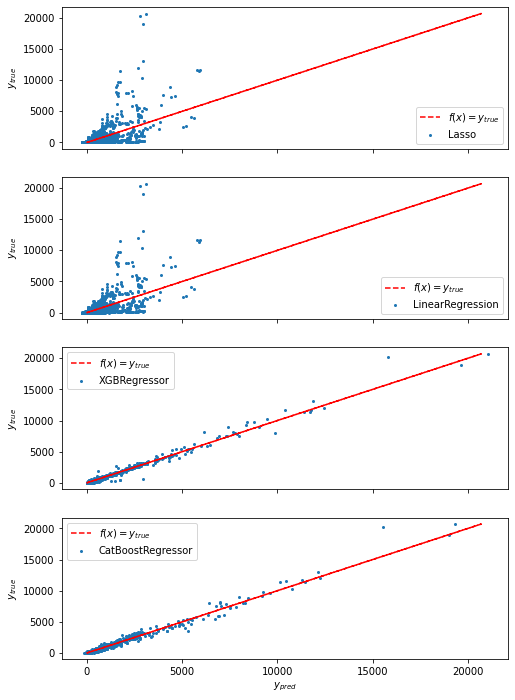

In [ ]:
fig,ax = plt.subplots(len(models),1,figsize=(8,12),sharex=True)
for idx,model in enumerate(models):
  curr_pred = model.predict(X_test)
  ax[idx].scatter(y_test,curr_pred,label=model.__class__.__name__,s=4)
  ax[idx].plot(y_test,y_test,'r--',label=r'$f(x) = y_{true}$')
  ax[idx].set_ylabel(r"$y_{pred}$")
  ax[idx].legend()
ax[idx].set_xlabel(r"$y_{true}$")

Podemos perceber que os modelos CatBoost e XGBoost concentram suas predições ao longo da diagonal, i.e., possuem uma distribuição mais próxima da real, enquanto os modelos baseline não conseguem se adaptar à distribuição real. Além disso, podemos formular uma hipótese para a diferença entre o erro médio para o XGBoost e o Catboost, i.e., será que a média dos erros do XGBoost para os 25 treinamentos de acordo com a métrica L1 é diferente quando da média dos erros do CatBoost de forma significativa? Ou será que o acaso pode explicar isso?

In [ ]:
def shuffle_data_models(df:pd.DataFrame,num_samples:int=10000) -> np.array:
    diffs = np.zeros(num_samples)
    filter = df['model'] == 'xgb'
    for i in range(num_samples):
        np.random.seed(i)
        np.random.shuffle(filter.values)
        diffs[i] = df[filter]['mae'].mean() - df[~filter]['mae'].mean()
    return diffs

In [ ]:
# Primeiramente iremos criar dois arrays contendo os erros médios para os modelos de acordo com os 25 treinamento realizados
xgb_errors = model_errors['XGBRegressor']
cb_errors = model_errors['CatBoostRegressor']

xgb_errors = np.array([[int(i),'xgb'] for i in xgb_errors],dtype=object)
cb_errors = np.array([[int(i),'cb'] for i in cb_errors],dtype=object)

#Agora calculamos a estatística real

original_stat = xgb_errors[:,0].mean() - cb_errors[:,0].mean()
original_stat

-16.360000000000003

In [ ]:
errors_df = pd.DataFrame(np.concatenate([xgb_errors,cb_errors],axis=0),columns=['mae','model'])
diffs = shuffle_data_models(errors_df)

p_value = (diffs < original_stat).mean() # Sinal de menos pois a diferênca é negativa
print(f"O P-valor calculado(5% de significância) foi: {p_value}")

O P-valor calculado(5% de significância) foi: 0.0


O teste de hipótese portanto nos permite concluir que a diferênça no erro médio entre o XGBoost e o CatBoost nos treinamento realizados não pode ser explicada pelo acaso, o que é um bom indicador da robustez do modelo XGBoost

Percebemos que o modelo XGBoost é claramente mais efetivos que as baselines do Lasso e da Regressão Linear, e também mais efetivo que o CatBoost, no entanto, realizamos uma seleção de hyperparâmetros um tanto arbitrária para o modelo e portanto agora realizaremos um grid search para obter os melhores hiperparâmetros

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_xgb = {'n_estimators':[100,300,500],'max_depth':[1,5,10,20],'objective':['reg:squarederror']}
xgb_reg = xgb.XGBRegressor()
clf = GridSearchCV(xgb_reg,param_grid_xgb,cv=5,verbose=4,refit=True)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=1, n_estimators=100, objective=reg:squarederror;, score=0.368 total time=   0.4s
[CV 2/5] END max_depth=1, n_estimators=100, objective=reg:squarederror;, score=0.413 total time=   0.4s
[CV 3/5] END max_depth=1, n_estimators=100, objective=reg:squarederror;, score=0.428 total time=   0.4s
[CV 4/5] END max_depth=1, n_estimators=100, objective=reg:squarederror;, score=0.387 total time=   0.4s
[CV 5/5] END max_depth=1, n_estimators=100, objective=reg:squarederror;, score=0.459 total time=   0.4s
[CV 1/5] END max_depth=1, n_estimators=300, objective=reg:squarederror;, score=0.404 total time=   1.2s
[CV 2/5] END max_depth=1, n_estimators=300, objective=reg:squarederror;, score=0.446 total time=   1.2s
[CV 3/5] END max_depth=1, n_estimators=300, objective=reg:squarederror;, score=0.464 total time=   1.2s
[CV 4/5] END max_depth=1, n_estimators=300, objective=reg:squarederror;, score=0.422 total time=   1.2s
[CV

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'n_estimators': [100, 300, 500],
                         'objective': ['reg:squarederror']},
             verbose=4)

In [ ]:
best_xgb = clf.best_estimator_ 
print(best_xgb)

XGBRegressor(max_depth=10, n_estimators=500, objective='reg:squarederror')


Agora iremos plotar alguns gráficos dos resultados obtidos para a regressão

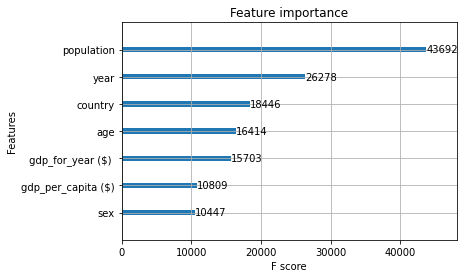

In [ ]:
# Plot de importância para o XGBoost, que informa o quão relevante foi cada feature para a predição final do modelo
from xgboost import plot_importance
plot_importance(best_xgb)

Por fim, iremos realizar uma análise da qualidade do modelo

[]

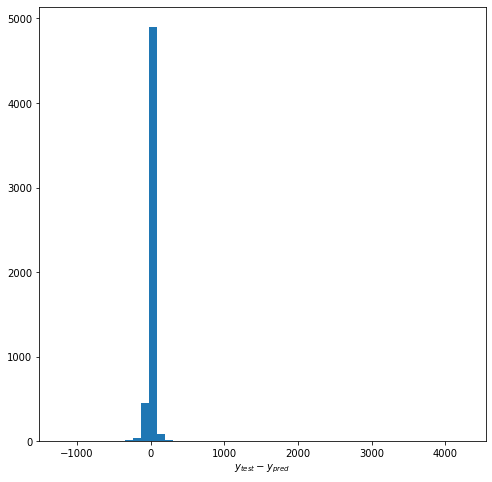

In [ ]:
# Distribuição dos erros
xgb_errors = y_test - best_xgb.predict(X_test)
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(xgb_errors,50)
ax.set_xlabel("$y_{test} - y_{pred}$")
plt.plot()

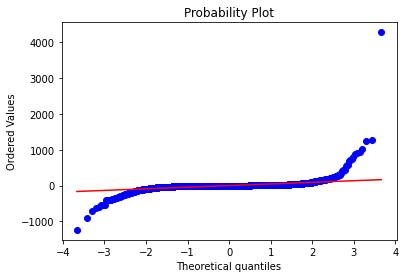

In [ ]:
# QQ Plot
from scipy import stats as ss
ss.probplot(xgb_errors, plot=plt.gca());

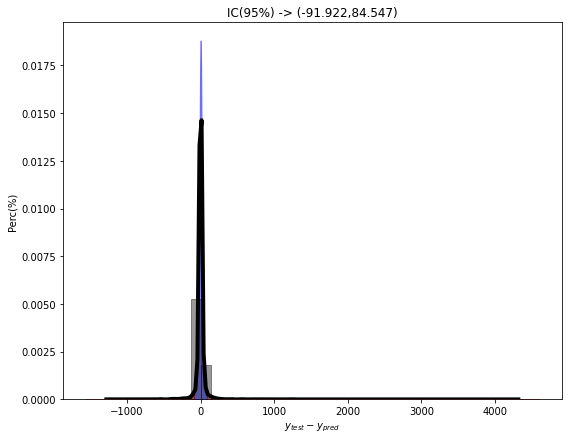

In [ ]:
# Intervalo de confiança de 95% para os erros do XGBoost no conjunto de teste
plot_ci(xgb_errors.to_numpy(),95,xlabel=r'$y_{test} - y_{pred}$',ylabel="Perc(%)")

De modo geral, dentre os modelos analizados, o XGBoost de fato aparenta ser um modelo razoável para prever o número de suicídios de um gruopo demográfico de um país em um dado ano. Além disso, conseguimos perceber que a feature mais relevante para a decisão do modelo foi de fato a feature "população".

Agora, realizaremos alguns estudos de caso:

In [ ]:
study_examples = np.random.choice(X_test.index,5)
study_df = old_df.iloc[study_examples][['country','year','sex','age','generation','population','suicides_no']]
study_df.head()

,country,year,sex,age,generation,population,suicides_no
5262,Canada,2013,female,5-14 years,Generation Z,1823010,20
5300,Chile,1988,male,75+ years,G.I. Generation,106000,29
22412,Singapore,1986,female,75+ years,G.I. Generation,26000,30
8083,El Salvador,1991,male,35-54 years,Boomers,434946,76
5601,Chile,2013,male,55-74 years,Boomers,1296922,288


In [ ]:
model_predictions = best_xgb.predict(X_test.loc[study_examples])
study_df['xgb_predictions'] = model_predictions
study_df.head()

,country,year,sex,age,generation,population,suicides_no,xgb_predictions
234,Albania,2008,female,35-54 years,Boomers,393832,19,6.030063
15765,Maldives,2007,male,15-24 years,Millenials,48015,1,2.843393
27363,Uruguay,1998,female,5-14 years,Millenials,262973,0,3.305648
25731,Turkmenistan,1987,female,5-14 years,Generation X,417000,4,5.078501
5201,Canada,2008,female,75+ years,Silent,1296269,38,49.774113


Por fim, iremos nos fazer a seguinte pergunta: "Será que o modelo está sendo tendencioso para algum ano específico?" Para responder a pergunta em questão, iremos analizar o erro médio do modelo para cada ano

1985 -> Test Error: 31.07 (n_samples = 106)
1986 -> Test Error: 28.52 (n_samples = 138)
1987 -> Test Error: 16.82 (n_samples = 132)
1988 -> Test Error: 19.78 (n_samples = 128)
1989 -> Test Error: 23.22 (n_samples = 117)
1990 -> Test Error: 19.00 (n_samples = 140)
1991 -> Test Error: 18.77 (n_samples = 156)
1992 -> Test Error: 18.65 (n_samples = 155)
1993 -> Test Error: 45.66 (n_samples = 155)
1994 -> Test Error: 29.12 (n_samples = 150)
1995 -> Test Error: 23.21 (n_samples = 198)
1996 -> Test Error: 25.82 (n_samples = 198)
1997 -> Test Error: 25.29 (n_samples = 163)
1998 -> Test Error: 18.65 (n_samples = 183)
1999 -> Test Error: 22.48 (n_samples = 201)
2000 -> Test Error: 17.89 (n_samples = 210)
2001 -> Test Error: 20.18 (n_samples = 203)
2002 -> Test Error: 17.77 (n_samples = 214)
2003 -> Test Error: 18.69 (n_samples = 215)
2004 -> Test Error: 23.86 (n_samples = 208)
2005 -> Test Error: 19.19 (n_samples = 223)
2006 -> Test Error: 15.20 (n_samples = 195)
2007 -> Test Error: 25.91 (n_sam

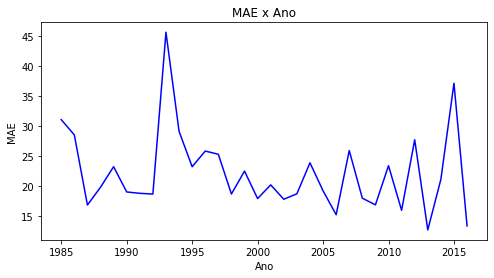

In [ ]:
year_errors = {}
years = []
errors = []
num_samples = []
for year,test_data in X_test.groupby('year'):
    xgb_pred = best_xgb.predict(test_data)
    curr_y = y_test.loc[test_data.index]
    curr_error = mean_absolute_error(curr_y,xgb_pred)
    print(f"{year} -> Test Error: {curr_error:.2f} (n_samples = {len(curr_y)})")
    years.append(year)
    errors.append(curr_error)
    num_samples.append(len(curr_y))

fix,ax = plt.subplots(1,1,figsize=(8,4))
ax.set_xlabel('Ano')
ax.set_ylabel('MAE')
ax.set_title("MAE x Ano")
ax.plot(years,errors,'b',ms='4')

O erro por ano do modelo náo apresenta nenhum padrão claro, mas podemos perceber que de fato o modelo possui um erro significativamente mais alto para o ano de 1993

# Conclusão

Por fim, concluímos que a análise dos dados em questão foi extremamente interessante para entender os padrões relacionados à suicídios em diversos países, mais especificamente no Brasil e nos Eua. De forma geral, a taxa de suicídios em ambos os países parece estar crescendo nos últimos anos, e isso talvez seja uma tendência que pode continuar. Com relação à modelagem, podemos perceber que é possível construir um modelo de regressão que é capaz de prever o número de suicídios para uma dada faixa etária de um país, quando consideramos os melhores modelos de boosting disponíveis atualmente. De forma geral, o estudo realizado foi satisfatório e rendeu resultados interessantes